In [203]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle

import torch

from typing import Tuple, List

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score

from torch.utils.data import Dataset, DataLoader

from sklearn.linear_model import LogisticRegression

import pytorch_lightning as pl

from time import time

from pytorch_lightning.loggers import WandbLogger

# Writing stuff with bare torch

In [2]:
# loading and shuffling the data
iris_dataset = datasets.load_iris()
x, y = iris_dataset.data, iris_dataset.target
x, y = shuffle(x, y, random_state=42)

In [3]:
# scaling the data
sc = StandardScaler()
x = sc.fit_transform(x)

In [23]:
# converting the data to tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)

x.shape, y.shape

/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_65594/2759068454.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_65594/2759068454.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.int64)


(torch.Size([150, 4]), torch.Size([150]))

In [58]:
# constructing the model

N_CLASSES = 4
N_FEATURES = 4

g = torch.Generator().manual_seed(42) 

## Model parameters
W = torch.randn(N_FEATURES, N_CLASSES, requires_grad=True, generator=g)
b = torch.randn(N_CLASSES, requires_grad=True, generator=g)

params = [W, b]

In [64]:
lossi: List[float] = []

def split_data_into_batches(x: torch.Tensor, y: torch.Tensor, batch_size: int = 32) -> Tuple[torch.Tensor, torch.Tensor]:
    x, y = shuffle(x, y, random_state=42)
    x_batches = torch.split(x, batch_size)
    y_batches = torch.split(y, batch_size)
    return (x_batches, y_batches)

# constructing the training loop
EPOCHS_COUNT = 1000
LEARNING_RATE = 0.01
BATCH_SIZE = 32

for i in range(EPOCHS_COUNT):
    # constructing the batches
    for x_batch, y_batch in zip(*split_data_into_batches(x, y)):
        logits = x_batch @ W + b

        for p in params:
            p.grad = None
        
        loss = torch.nn.functional.cross_entropy(logits, y_batch)

        loss.backward()



        for p in params:
            p.data -= LEARNING_RATE * p.grad
    lossi.append(loss.item())
    if i % 100 == 0:
        print(f"Epoch {i}: {loss}")

Epoch 0: 0.1313977837562561
Epoch 100: 0.1298086792230606
Epoch 200: 0.12833267450332642
Epoch 300: 0.12695850431919098
Epoch 400: 0.1256764531135559
Epoch 500: 0.12447767704725266
Epoch 600: 0.12335468083620071
Epoch 700: 0.12230078876018524
Epoch 800: 0.12130998820066452
Epoch 900: 0.12037653475999832


Text(0, 0.5, 'Loss')

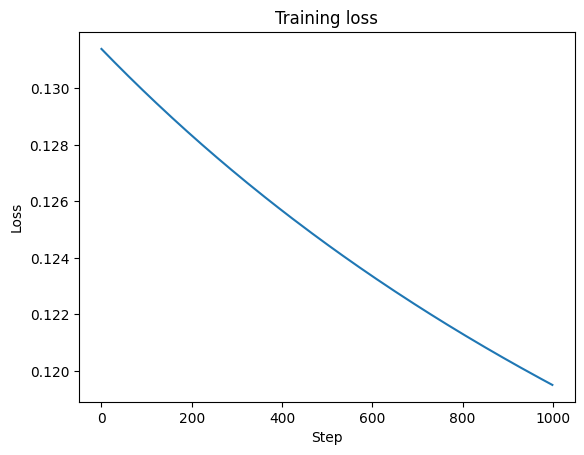

In [65]:
plt.plot(lossi)
plt.title("Training loss")
plt.xlabel("Step")
plt.ylabel("Loss")

In [78]:
# getting the predictions

logits = x @ W + b
probs = torch.nn.functional.softmax(logits, dim=1)
y_pred = torch.argmax(probs, dim=1)

In [79]:
# checking the accuracy
print(classification_report(y, y_pred))
print(accuracy_score(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      0.94      0.95        50
           2       0.94      0.96      0.95        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

0.9666666666666667


In [80]:
# checking the logistic regression

logreg = LogisticRegression()
logreg.fit(x, y)
y_pred = logreg.predict(x)
print(classification_report(y, y_pred))
print(accuracy_score(y, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.94      0.96        50
           2       0.94      0.98      0.96        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

0.9733333333333334


## Implementing binary classification

In [138]:
# loading and shuffling the data
iris_dataset = datasets.load_iris()
x, y = iris_dataset.data, iris_dataset.target
x = x[:100]
y = y[:100]
x, y = shuffle(x, y, random_state=42)

In [139]:
# scaling the data
sc = StandardScaler()
x = sc.fit_transform(x)

In [140]:
# converting the data to tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

x.shape, y.shape

(torch.Size([100, 4]), torch.Size([100]))

In [141]:
# constructing the model

N_CLASSES = 1
N_FEATURES = 4

g = torch.Generator().manual_seed(42) 

## Model parameters
W = torch.randn(N_FEATURES, N_CLASSES, requires_grad=True, generator=g)
b = torch.randn(N_CLASSES, requires_grad=True, generator=g)

params = [W, b]

In [144]:
lossi: List[float] = []

def split_data_into_batches(x: torch.Tensor, y: torch.Tensor, batch_size: int = 32) -> Tuple[torch.Tensor, torch.Tensor]:
    x, y = shuffle(x, y, random_state=42)
    x_batches = torch.split(x, batch_size)
    y_batches = torch.split(y, batch_size)
    return (x_batches, y_batches)

# constructing the training loop
EPOCHS_COUNT = 1000
LEARNING_RATE = 0.01
BATCH_SIZE = 16

for i in range(EPOCHS_COUNT):
    # constructing the batches
    for x_batch, y_batch in zip(*split_data_into_batches(x, y)):
        logits = x_batch @ W + b
        probs = torch.nn.functional.sigmoid(logits)

        for p in params:
            p.grad = None
        loss = torch.nn.functional.binary_cross_entropy(probs.view(-1), y_batch)

        loss.backward()


        for p in params:
            p.data -= LEARNING_RATE * p.grad
    lossi.append(loss.item())
    if i % 100 == 0:
        print(f"Epoch {i}: {loss}")

/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0: 0.4973945915699005
Epoch 100: 0.08856496959924698
Epoch 200: 0.04850699380040169
Epoch 300: 0.0347980372607708
Epoch 400: 0.027835438027977943
Epoch 500: 0.023549729958176613
Epoch 600: 0.02059999294579029
Epoch 700: 0.018418805673718452
Epoch 800: 0.016724668443202972
Epoch 900: 0.015361283905804157


Text(0, 0.5, 'Loss')

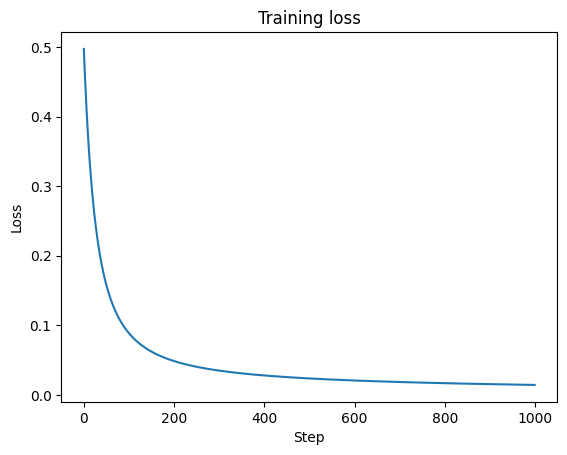

In [145]:
plt.plot(lossi)
plt.title("Training loss")
plt.xlabel("Step")
plt.ylabel("Loss")

In [146]:
# getting the predictions

logits = x @ W + b
probs = torch.nn.functional.sigmoid(logits)
y_pred =(probs > 0.5).int().view(-1).tolist()

In [147]:
# checking the accuracy
print(classification_report(y, y_pred))
print(accuracy_score(y, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        50
         1.0       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

1.0


In [148]:
# checking the logistic regression

logreg = LogisticRegression()
logreg.fit(x, y)
y_pred = logreg.predict(x)
print(classification_report(y, y_pred))
print(accuracy_score(y, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        50
         1.0       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

1.0


# Writing same stuff with torch.Module

In [156]:
# definig the iris dataset

class IrisDataset(Dataset):
    def __init__(self):
        iris_data = datasets.load_iris()
        self.x = iris_data.data
        self.y = iris_data.target

        self._scaler = StandardScaler()
        self._scaler.fit(self.x)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x_scaled = self._scaler.transform(self.x[idx].reshape(1, -1))[0]
        return x_scaled, self.y[idx]

In [169]:
LEARNING_RATE = 0.01
BATCH_SIZE = 32

## Model parameters
l1 = torch.nn.Linear(4, 4, dtype=torch.float64)
optimizer = torch.optim.SGD(l1.parameters(), lr=0.01, momentum=0.9)

In [170]:
dataset = IrisDataset()

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [171]:
lossi: List[float] = []

# constructing the training loop
EPOCHS_COUNT = 1000

for i in range(EPOCHS_COUNT):
    # constructing the batches
    for x_batch, y_batch in dataloader:
        logits = l1(x_batch)

        loss = torch.nn.functional.cross_entropy(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    lossi.append(loss.item())
    if i % 100 == 0:
        print(f"Epoch {i}: {loss}")

Epoch 0: 1.1681102995430268
Epoch 100: 0.18478613936761432
Epoch 200: 0.15108114006982418
Epoch 300: 0.12051445495266706
Epoch 400: 0.10178242188881806
Epoch 500: 0.06162039707941394
Epoch 600: 0.08114879209873836
Epoch 700: 0.10771376643983373
Epoch 800: 0.0627352267123836
Epoch 900: 0.03846148208439135


Text(0, 0.5, 'Loss')

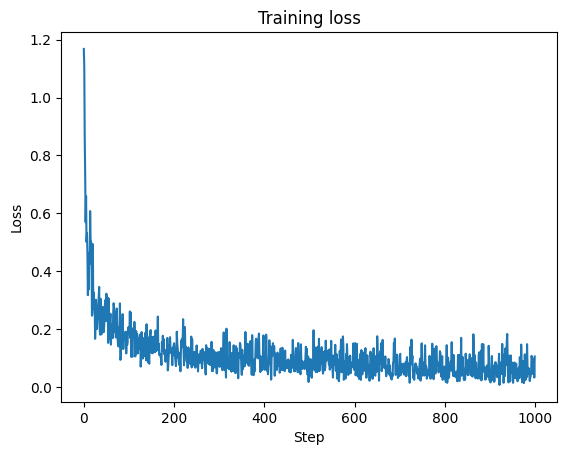

In [172]:
plt.plot(lossi)
plt.title("Training loss")
plt.xlabel("Step")
plt.ylabel("Loss")

In [181]:
# getting the predictions

y_pred = []
y_true = []

for x_batch, y_batch in dataloader:
    logits = l1(x_batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    y_pred.extend(torch.argmax(probs, dim=1).tolist())
    y_true.extend(y_batch.tolist())

In [182]:
# checking the accuracy
print(classification_report(y_true, y_pred))
print(accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.94      0.96        50
           2       0.94      0.98      0.96        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

0.9733333333333334


# Rewriting all with Pytorch Lightning

In [206]:
# defining the model

class IrisModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(4, 4, dtype=torch.float64)

    def forward(self, x):
        x = self.l1(x)
        return x

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = torch.nn.functional.cross_entropy(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = torch.nn.functional.cross_entropy(logits, y)

In [199]:
LEARNING_RATE = 0.01
BATCH_SIZE = 32

In [207]:
dataset = IrisDataset()
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [208]:
wandb_logger = WandbLogger(project="codeacademy2", name=f"iris_model_{int(time())}", log_model=True)

/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [209]:
# constructing the training loop

model = IrisModel()
trainer = pl.Trainer(max_epochs=1000, logger=wandb_logger)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [210]:
trainer.fit(model, train_dataloaders=dataloader)

/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 20    
--------------------------------
20        Trainable params
0         Non-trainable params
20        Total params
0.000     Total estimated model params size (MB)
/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site

Epoch 999: 100%|██████████| 5/5 [00:00<00:00, 232.52it/s, loss=0.0648, v_num=2crd]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 5/5 [00:00<00:00, 196.57it/s, loss=0.0648, v_num=2crd]


In [211]:
# getting the predictions

y_pred = []
y_true = []

for x_batch, y_batch in dataloader:
    logits = model.forward(x_batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    y_pred.extend(torch.argmax(probs, dim=1).tolist())
    y_true.extend(y_batch.tolist())

In [212]:
# checking the accuracy
print(classification_report(y_true, y_pred))
print(accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.96      0.97        50
           2       0.96      0.98      0.97        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

0.98
